# MST Implementation on Qiskit

Some sections of the code have been obtained from the contents on: 

In [1]:
# Necessary Libraries for program execution
import networkx as nx
import numpy as np
from qiskit_algorithms.utils import algorithm_globals
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from networkx import Graph
import matplotlib.pyplot as plt
import matplotlib.colors as c
import random
from qiskit_optimization import QuadraticProgram
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_optimization.converters import QuadraticProgramToQubo
from typing import Tuple
import plotly.graph_objects as go


## 1. Parameter Selection
Choose the desired parameters to configure the creation of a Max-Cut Algorithm
- Seed for the random value generation to obtain different results with similar parameters, or set it to None in case you want to create random graphs every time
- n for the total number of nodes in the problem
- p for the probability of generating and edge between two nodes
- minimum_weight for the minimum edge weight
- maximum_weight for the maximum edge weight

In [2]:
seed = 123
n = 5
p = 0.5
minimum_weight = 1
maximum_weight = 10

In [3]:
def draw_graph(G, seed, result_variables: list = None):
    # position is stored as node attribute data for random_geometric_graph
    pos = nx.spring_layout(G, seed=seed)  # Seed for reproducible layout
    flag = False
    if result_variables is not None:
        for var in result_variables:
            split = var.split('_')
            if len(split) > 2 and split[0] == 'x':
                flag = True
                i = 0
                j = 0
                try:
                  i = int(split[1])
                  j = int(split[2])
                except ValueError:
                  flag = False
                if flag:
                    if result_variables[var] != 0:
                        G[i][j]['color'] = c.to_rgba('b', 1)
                    else:
                        G[i][j]['color'] = c.to_rgba('b', 0.3)
    

    labels = {}
    for i in range(G.number_of_nodes()):
        labels[i] = str(i)
    nx.draw_networkx_nodes(G, pos, label=labels)
    labels = nx.get_edge_attributes(G,'weight')
    if flag:
        colors = []
        for edge in G.edges():
            colors.append(G[edge[0]][edge[1]]['color'])
        nx.draw_networkx_edges(G, pos, edgelist=labels, edge_color=colors, width=4)
    else:
        nx.draw_networkx_edges(G, pos, edgelist=labels, width=4)  
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    nx.draw_networkx_labels(G, pos)
    plt.show()


### 2. Create a Graph

In [4]:
def create_random_instance(n: int, low: int = 0, high: int = 100, p: float = 1, seed: int = None) -> Graph:
    """Create a random instance of a Graph with n nodes and p probability of having weighted edges between nodes.

    Args:
        n: the number of nodes.
        low: The minimum value for the coordinate of a node.
        high: The maximum value for the coordinate of a node.
        seed: the seed for the random values.
        p: the probability that the node is visited.

    Returns:
         A Graph instance created from the input information
    """
    if seed:
        algorithm_globals.random_seed = seed
        random.seed(seed)
    #coord = algorithm_globals.random.uniform(low, high, (n, 2))
    #pos = {i: (coord_[0], coord_[1]) for i, coord_ in enumerate(coord)}
    gen_graph = nx.erdos_renyi_graph(n, p, seed=seed)
    for i, j in gen_graph.edges:
        gen_graph.edges[i, j]["weight"] = random.randint(low, high)
    return gen_graph

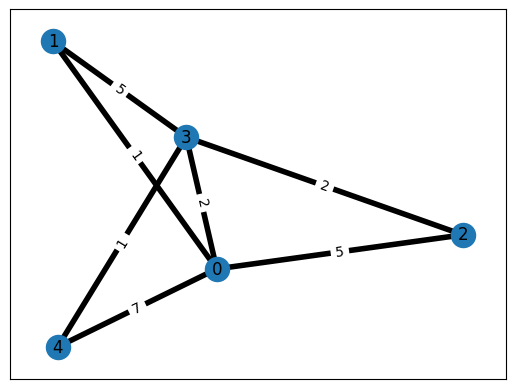

[(0, 1, {'weight': 1}), (0, 2, {'weight': 5}), (0, 3, {'weight': 2}), (0, 4, {'weight': 7}), (1, 3, {'weight': 5}), (2, 3, {'weight': 2}), (3, 4, {'weight': 1})]


"\nfor edge in graph.edges():\n    print(edge, graph[edge[0]][edge[1]]['weight'])\n"

In [5]:
graph = create_random_instance(n=n, low=minimum_weight, high=maximum_weight, p=p, seed=seed)
draw_graph(graph, seed)
print(graph.edges.data())
'''
for edge in graph.edges():
    print(edge, graph[edge[0]][edge[1]]['weight'])
'''

## 3. Define the Quadratic Program
In this stage we will translate the MST problem to solve in Graph format to a Quadratic Program 

### Binary Variable Assignation
Each edge is assigned a binary variable, however each edge is represented only once, so we need to decided in one direction (in this case from minimum node index to maximum node index).
### Objective Function Definition
The objective function needs to be defined as the linear cost function we are looking forward to minimize. In this case, we are taking the values of each of the edges and mapping their weights
### Degree Constraint
We set a constraint to make sure that the total number of edges that the MST cut contains is equal to the number of vertices in the graph minus one, ensuring that the spanning tree's edges cover all of the vertices. 
### Cycle Constraints
The Miller-Tucker-Zemlin (MTZ) formulation is used to eliminate the close cycles that can form when looking for solutions, ensuring we have an acyclical valid spanning tree.
We introduce a continuous variable u for each vertex v except for a fixed root vertex (commonly vertex 0). These variables help to order the vertices in such a way that any inclusion of an edge in the MST maintains a valid order., where u ranges from 0 to n - 1.

The continuous variables u act like position indicators for vertices. They help in defining an order or hierarchy among vertices.
The MTZ constraints ensure that if an edge is included in the MST, the order of vertices as indicated by the continuous variables will prevent cycles from forming. By ensuring that ui and uj maintain a consistent order whenever an edge (i,j) is selected, we ensure the acyclic nature of the resulting graph.

However, with the help of binary indicators, we are able to circumvent this problem through thee usage of binary indicators that they are used.

In [6]:
def mst_to_quadratic_program(G) -> QuadraticProgram:
    """Convert a MST graph problem instance into a
    :class:`~qiskit_optimization.problems.QuadraticProgram`

    Returns:
        The :class:`~qiskit_optimization.problems.QuadraticProgram` created
        from the MST graph problem instance.
    """
    qp = QuadraticProgram("MST")
    
    # Add binary variables for each edge
    for u, v in G.edges():
        qp.binary_var(name=f"x_{min(u, v)}_{max(u, v)}")
    
    # Add linear constraint (objective function)
    linear = {f"x_{min(u, v)}_{max(u, v)}": G[u][v]['weight'] for u, v in G.edges()}
    qp.minimize(linear=linear)
    
    # Add degree constraint
    vertices = list(G.nodes())
    qp.linear_constraint(
        linear={f"x_{min(u, v)}_{max(u, v)}": 1 for u, v in G.edges()},
        sense='==',
        rhs=len(vertices) - 1
    )
    
    '''
    # Add cycle constraints
    # Using a binary indicator approach to ensure connectivity
    for v in vertices[1:]:
        for u in vertices:
            if u != v and G.has_edge(u, v):
                qp.linear_constraint(
                    linear={f"x_{min(u, v)}_{max(u, v)}": 1},
                    sense='<=',
                    rhs=1
                )
    '''
    return qp

In [7]:
qp = mst_to_quadratic_program(graph)
print(qp.prettyprint())

Problem name: MST

Minimize
  x_0_1 + 5*x_0_2 + 2*x_0_3 + 7*x_0_4 + 5*x_1_3 + 2*x_2_3 + x_3_4

Subject to
  Linear constraints (1)
    x_0_1 + x_0_2 + x_0_3 + x_0_4 + x_1_3 + x_2_3 + x_3_4 == 4  'c0'

  Binary variables (7)
    x_0_1 x_0_2 x_0_3 x_0_4 x_1_3 x_2_3 x_3_4



## 4. Convert to QUBO

In [8]:
#Alternative to Ising implementation, without optimizing the matrix
def custom_to_ising(quad_prog: QuadraticProgram) -> Tuple[SparsePauliOp, float]:
    # if problem has variables that are not binary, raise an error
    if quad_prog.get_num_vars() > quad_prog.get_num_binary_vars():
        raise QiskitOptimizationError(
            "The type of all variables must be binary. "
            "You can use `QuadraticProgramToQubo` converter "
            "to convert integer variables to binary variables. "
            "If the problem contains continuous variables, `to_ising` cannot handle it. "
            "You might be able to solve it with `ADMMOptimizer`."
        )

    # if constraints exist, raise an error
    if quad_prog.linear_constraints or quad_prog.quadratic_constraints:
        raise QiskitOptimizationError(
            "There must be no constraint in the problem. "
            "You can use `QuadraticProgramToQubo` converter "
            "to convert constraints to penalty terms of the objective function."
        )

    # initialize Hamiltonian.
    num_vars = quad_prog.get_num_vars()
    pauli_list = []
    offset = 0.0
    zero = np.zeros(num_vars, dtype=bool)

    # set a sign corresponding to a maximized or minimized problem.
    # sign == 1 is for minimized problem. sign == -1 is for maximized problem.
    sense = quad_prog.objective.sense.value

    # convert a constant part of the objective function into Hamiltonian.
    offset += quad_prog.objective.constant * sense

    # convert linear parts of the objective function into Hamiltonian.
    for idx, coef in quad_prog.objective.linear.to_dict().items():
        z_p = zero.copy()
        weight = coef * sense / 2
        z_p[idx] = True

        pauli_list.append(SparsePauliOp(Pauli((z_p, zero)), -weight))
        offset += weight

    # create Pauli terms
    for (i, j), coeff in quad_prog.objective.quadratic.to_dict().items():
        weight = coeff * sense / 4

        if i == j:
            offset += weight
        else:
            z_p = zero.copy()
            z_p[i] = True
            z_p[j] = True
            pauli_list.append(SparsePauliOp(Pauli((z_p, zero)), weight))

        z_p = zero.copy()
        z_p[i] = True
        pauli_list.append(SparsePauliOp(Pauli((z_p, zero)), -weight))

        z_p = zero.copy()
        z_p[j] = True
        pauli_list.append(SparsePauliOp(Pauli((z_p, zero)), -weight))

        offset += weight

    if pauli_list:
        # Remove paulis whose coefficients are zeros.
        print("List of size ", len(pauli_list), pauli_list)
        print("Sum of size ", len(sum(pauli_list)), sum(pauli_list))
        qubit_op = sum(pauli_list).simplify(atol=0)
    else:
        # If there is no variable, we set num_nodes=1 so that qubit_op should be an operator.
        # If num_nodes=0, I^0 = 1 (int).
        num_vars = max(1, num_vars)
        qubit_op = SparsePauliOp("I" * num_vars, 0)

    return qubit_op, offset

In [9]:
# Regular approach with external library
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)

# Custom implementation
qubitOp, offset = custom_to_ising(qubo)

# Regular implementation
qubitOp, offset = qubo.to_ising()
print("Standard QUBO:", qubitOp)

List of size  84 [SparsePauliOp(['IIIIIIZ'],
              coeffs=[95.5+0.j]), SparsePauliOp(['IIIIIZI'],
              coeffs=[93.5+0.j]), SparsePauliOp(['IIIIZII'],
              coeffs=[95.+0.j]), SparsePauliOp(['IIIZIII'],
              coeffs=[92.5+0.j]), SparsePauliOp(['IIZIIII'],
              coeffs=[93.5+0.j]), SparsePauliOp(['IZIIIII'],
              coeffs=[95.+0.j]), SparsePauliOp(['ZIIIIII'],
              coeffs=[95.5+0.j]), SparsePauliOp(['IIIIIIZ'],
              coeffs=[-6.+0.j]), SparsePauliOp(['IIIIIIZ'],
              coeffs=[-6.+0.j]), SparsePauliOp(['IIIIIZZ'],
              coeffs=[12.+0.j]), SparsePauliOp(['IIIIIIZ'],
              coeffs=[-12.+0.j]), SparsePauliOp(['IIIIIZI'],
              coeffs=[-12.+0.j]), SparsePauliOp(['IIIIZIZ'],
              coeffs=[12.+0.j]), SparsePauliOp(['IIIIIIZ'],
              coeffs=[-12.+0.j]), SparsePauliOp(['IIIIZII'],
              coeffs=[-12.+0.j]), SparsePauliOp(['IIIZIIZ'],
              coeffs=[12.+0.j]), SparsePauliOp

### Not very Important Functions stolen from Qiskit
https://qiskit-community.github.io/qiskit-optimization/_modules/qiskit_optimization/applications/optimization_application.html#OptimizationApplication.sample_most_likely

In [10]:
from typing import Dict, Union
from qiskit.quantum_info import Statevector
from qiskit.result import QuasiDistribution
from collections import OrderedDict
def sample_most_likely(
        state_vector: Union[QuasiDistribution, Statevector, np.ndarray, Dict]
    ) -> np.ndarray:
        """Compute the most likely binary string from state vector.

        Args:
            state_vector: state vector or counts or quasi-probabilities.

        Returns:
            binary string as numpy.ndarray of ints.

        Raises:
            ValueError: if state_vector is not QuasiDistribution, Statevector,
                np.ndarray, or dict.
        """
        if isinstance(state_vector, QuasiDistribution):
            probabilities = state_vector.binary_probabilities()
            binary_string = max(probabilities.items(), key=lambda kv: kv[1])[0]
            x = np.asarray([int(y) for y in reversed(list(binary_string))])
            return x
        elif isinstance(state_vector, Statevector):
            probabilities = state_vector.probabilities()
            n = state_vector.num_qubits
            k = np.argmax(np.abs(probabilities))
            x = np.zeros(n)
            for i in range(n):
                x[i] = k % 2
                k >>= 1
            return x
        elif isinstance(state_vector, (OrderedDict, dict)):
            # get the binary string with the largest count
            binary_string = max(state_vector.items(), key=lambda kv: kv[1])[0]
            x = np.asarray([int(y) for y in reversed(list(binary_string))])
            return x
        elif isinstance(state_vector, np.ndarray):
            n = int(np.log2(state_vector.shape[0]))
            k = np.argmax(np.abs(state_vector))
            x = np.zeros(n)
            for i in range(n):
                x[i] = k % 2
                k >>= 1
            return x
        else:
            raise ValueError(
                "state vector should be QuasiDistribution, Statevector, ndarray, or dict. "
                f"But it is {type(state_vector)}."
            )

## Checking the Full Hamiltonian gives the right cost

In [11]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("MST objective:", result.eigenvalue.real + offset)
x = sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))


energy: -53.5
MST objective: 6.0
feasible: True


## 5. Create QAOA Circuit

In [12]:
from qiskit.circuit.library.n_local.qaoa_ansatz import QAOAAnsatz
from qiskit.circuit import Parameter, ParameterVector

def qaoa_circuit_conversion(qubo: QuadraticProgram, p: int = 1):
    """
    Given a QUBO instance and the number of layers p, constructs the corresponding parameterized QAOA circuit with p layers.
    Args:
        qubo: The quadratic program instance
        p: The number of layers in the QAOA circuit
    Returns:
        The parameterized QAOA circuit
    """
    size = qubo.get_num_vars()
    operator, value = qubo.to_ising()
    
    qaoa_circuit = QAOAAnsatz(cost_operator=operator, reps=p)
    #parameters = [Parameter(f'γ_{i}') for i in range(p)] + [Parameter(f'β_{i}') for i in range(p)]
    #qaoa_circuit.assign_parameters(parameters, inplace=True)
    
    return qaoa_circuit

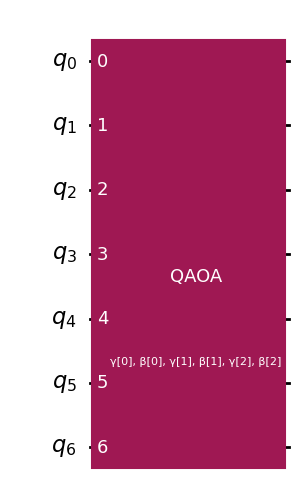

In [13]:
circuit = qaoa_circuit_conversion(qubo, p=3)
circuit.draw(output="mpl", idle_wires=False, style="iqp")

## 6. Hardware Execution

In [14]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator

service = QiskitRuntimeService(channel="ibm_quantum")

# To execute in real hardware, set this variable to true!
RUN_MODE = False

if RUN_MODE:
    # To run on hardware, select the backend with the fewest number of jobs in the queue
    backend = service.least_busy(operational=True, simulator=False)
else:
    real_backend = service.backend("ibm_brisbane")
    backend = AerSimulator.from_backend(real_backend)

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

KeyboardInterrupt: 

In [ ]:
# Executing Qiskit Primitives
session = Session(backend=backend)

# Configure estimator
estimator = Estimator(session=session)
estimator.options.default_shots = 10_000
estimator.options.dynamical_decoupling.enable = True

# Configure sampler
sampler = Sampler(session=session)
sampler.options.default_shots = 10_000
sampler.options.dynamical_decoupling.enable = True

### 6.1 Circuit Transpile

In [ ]:
# Ansatz Optimization
ansatz_isa = pm.run(circuit)
#ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

# ISA Observables
hamiltonian, _ = qubo.to_ising()
hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)
print(hamiltonian_isa)

In [ ]:
ansatz_isa.draw('mpl', style="iqp")



### 6.2 Estimating on Hardware

In [ ]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    cost = result[0].data.evs[0]

    return cost

In [ ]:
def build_callback(ansatz, hamiltonian, estimator, callback_dict):
    """Return callback function that uses Estimator instance,
    and stores intermediate values into a dictionary.

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        callback_dict (dict): Mutable dict for storing values

    Returns:
        Callable: Callback function object
    """

    def callback(current_vector):
        """Callback function storing previous solution vector,
        computing the intermediate cost value, and displaying number
        of completed iterations and average time per iteration.

        Values are stored in pre-defined 'callback_dict' dictionary.

        Parameters:
            current_vector (ndarray): Current vector of parameters
                                      returned by optimizer
        """
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        # This adds an additional function evaluation
        pub = (ansatz, [hamiltonian], [current_vector])
        result = estimator.run(pubs=[pub]).result()
        current_cost = result[0].data.evs[0]
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        print(
            "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
            end="\r",
            flush=True,
        )

    return callback

callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [ ]:
# SciPy minimizer routine
from scipy.optimize import minimize

# Initial Parameters
x0 = 2 * np.pi * np.random.rand(ansatz_isa.num_parameters)

with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 10000

    callback = build_callback(ansatz_isa, hamiltonian_isa, estimator, callback_dict)

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="COBYLA",
        callback=callback
    )
    print(res)

print(res.values())

### 6.3 Sampling on Hardware

In [ ]:
from qiskit.visualization import plot_distribution

# Assign solution parameters to ansatz
qc = circuit.assign_parameters(res.x)  
# Add measurements to our circuit
qc.measure_all()
qc_isa = pm.run(qc)
qc_isa.draw(output="mpl", idle_wires=False, style="iqp")
 
result = sampler.run([qc_isa]).result()
samp_dist = result[0].data.meas.get_counts()
# Close the session since we are now done with it
session.close()

plot_distribution(samp_dist, figsize=(30, 5))

## 7. Post-Processing

In [ ]:
def bitstring_to_edges(bitstring: str, G: Graph) -> list:
    """
    Translate a bitstring back to the selected edges in the graph.
    
    Args:
        bitstring (str): A bitstring representing the solution.
        G (Graph): The original graph.
    
    Returns:
        list: A list of edges (tuples) that are selected.
    """
    selected_edges = []
    edge_list = list(G.edges())
    
    # Iterate through the bitstring and the edges
    for bit, edge in zip(bitstring, edge_list):
        if bit == '1':
            selected_edges.append(edge)
    
    return selected_edges

In [ ]:
def cost_from_bistring(bitstring: str, qubo: QuadraticProgram) -> float:
    """
    Calculate the cost value of a bitstring for a given QUBO instance.

    Args:
        bitstring (str): A bitstring representing the solution.
        qubo (QuadraticProgram): A QUBO instance.

    Returns:
        float: The cost value of the bitstring.
    """
    
    # Convert bitstring to a numpy array of integers
    x = np.array([int(bit) for bit in bitstring])
    
    # Initialize cost
    cost = 0.0

    # Calculate linear term contribution
    for i, var in enumerate(qubo.objective.linear.to_dict()):
        cost += qubo.objective.linear[i] * x[i]

    # Calculate quadratic term contribution
    for (i, j), coeff in qubo.objective.quadratic.to_dict().items():
        cost += coeff * x[i] * x[j]

    return cost

In [ ]:
def calculate_cost_from_edges(selected_edges, qp):
    total_cost = 0.0
    
    cost_function = str(qp.objective)
    for edge in selected_edges:
        # Check if the edge exists in the quadratic program's objective function
        var = "x_"+ str(edge[0]) + "_" + str(edge[1])
        cost_function = cost_function.replace(var, "1")
    function_split = cost_function.split(" ")
    function_clean = []
    for term in function_split:
        if "m" not in term:
            if "x" not in term:
                function_clean.append(term)
            else:
                function_clean.append("0")
    function_string = "".join(function_clean)
    cost = eval(function_string)
    return cost

In [ ]:
def plot_samples(samples):
    """
    Plots a bar diagram for the samples of a quantum algorithm
    Args:
        samples
    """
    #Sort samples by probability
    samples = sorted(samples.items(), key=lambda kv: kv[1])
    
    # Reinterpret the bitstrings back to the original layout
    bitstrings = []
    for sample in samples:
        vars = []
        # Invert the bitstring because the results are inverted!
        for char in sample[0][::-1]:
            vars.append(int(char))
        bitstrings.append("".join(map(str, map(int, qp2qubo.interpret(vars).tolist()))))
    
    #Get list of probabilities, function values and bitstrings
    probabilities = [sample[1] for sample in samples]
    
    # Interpret the bitstrings back to the original shape
    values = [calculate_cost_from_edges(bitstring_to_edges(bitstring, graph), qp) for bitstring in bitstrings]
    alt_values = [value if graph.number_of_nodes() - 1 != len(bitstring_to_edges(bitstrings[idx], graph)) else -1 for idx, value in enumerate(values)]
    
    # Group bitstrings
    unique_bitstrings = []
    total_probs = []
    unique_values = []
    unique_alt_values = []
    for index, bit_string in enumerate(bitstrings): 
        if bit_string not in unique_bitstrings: 
            unique_bitstrings.append(bit_string)
            unique_values.append(values[index])
            unique_alt_values.append(alt_values[index])
            total_probs.append(0)
        total_probs[unique_bitstrings.index(bit_string)] += probabilities[index]
    
    #Plot bar diagram for frequency
    sample_plot = go.Bar(x = unique_bitstrings, y = total_probs, marker=dict(color=unique_alt_values, colorscale = 'plasma',colorbar=dict(title='Interpreted Function Value')))
    fig = go.Figure(
        data=sample_plot, 
        layout = dict(
            xaxis=dict(
                type = 'category'
            )
        )
    )
    fig.update_layout(barmode='stack', xaxis={'categoryorder':'total ascending'})
    fig.show()
        
    #print (unique_bitstrings, total_probs, unique_values)
    #Plot bar diagram for cost
    sample_plot = go.Bar(x = unique_bitstrings, y = total_probs, marker=dict(color=unique_values, colorscale = 'solar',colorbar=dict(title='Penalized Function Value')))
    fig = go.Figure(
        data=sample_plot, 
        layout = dict(
            xaxis=dict(
                type = 'category'
            )
        )
    )
    fig.update_layout(barmode='stack', xaxis={'categoryorder':'total ascending'})
    fig.show()

In [ ]:
plot_samples(samp_dist)
#print(samp_dist)

In [ ]:
## Checking QUBO
'''
# Print linear coefficients
print("Linear Coefficients:")
for i, coeff in enumerate(qubo.objective.linear.to_dict()):
    print(f"x_{i}: {coeff}")

# Print quadratic coefficients
print("Quadratic Coefficients:")
for (i, j), coeff in qubo.objective.quadratic.to_dict().items():
    print(f"x_{i} * x_{j}: {coeff}")

# Print the offset if applicable
if hasattr(qubo, 'offset'):
    print("Offset:", qubo.offset)
'''

In [ ]:
# Assuming samp_dist is a dictionary with bitstrings as keys and their counts as values
samples = list(sorted(samp_dist.items(), key=lambda kv: kv[1]))

samps = []
for bitstring, count in samples:
    vars = []
    for char in bitstring:
        vars.append(int(char))
    bitstring = "".join(map(str, map(int, qp2qubo.interpret(vars).tolist())))
    
    cost = cost_from_bistring(bitstring, qubo)
    samps.append([bitstring, count, cost])

samps.sort(key=lambda kv: kv[0])  # Sort by cost

for sample in samps:
    bitstring, count, cost = sample
    selected_edges = bitstring_to_edges(bitstring, graph)
    print(f"Cost: {cost}, from String: {bitstring}, with selected edges: {selected_edges}")


In [ ]:
'''
# Credentials Login
from qiskit_ibm_runtime import QiskitRuntimeService

gmail_token = 'ec8c90467f71da5bb79c7192307ad7e1adeb07cbffe3ffc4d9d3c9dfc61700ac672e478f753e611ba1dba599bcfce14ea118ab39e4a48793c9709f5706c0d85c'
token = "210b071a2d234c2363d69efbe21a792e4d11cbc52ac1e8c8caa4f2110fca3422dd63c308624c1df9956cfde32f5e3abc332b9a77b2a1283eada66cbc14c85f40"
QiskitRuntimeService.save_account(channel="ibm_quantum", token=gmail_token)
'''
#session.close()

In [ ]:
# Disable the current account
''''

import os

# Disable the current account
QiskitRuntimeService.delete_account()

# Delete the local file storing the token
config_path = os.path.expanduser("~/.qiskit/qiskit-ibm.json")
if os.path.exists(config_path):
    os.remove(config_path)
'''